

---


### **DSTPII + VAR + Correcteur PID**


---



In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Initialisation TPU

In [2]:
import os

use_tpu = True

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TPU_ADDRESS = ''

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.69.75.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.75.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


# Chargement et correction des données

Ce dataset est utilisé pour effectuer la prédiction de la température d'une pièce en fonction de plusieurs paramètres mesurés. La fréquence originale des données est d'une minute, puis a été modifiée à 15minutes avec un filtrage. L'ensemble correspond environ à une durée de 40 jours.  
Nous allons utiliser ici la température de la chambre comme cible et sélectionner 18 séries exogènes. 

**1. Chargement des données**

In [3]:
!rm *.txt
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/NEW-DATA-1.T15.txt"

rm: cannot remove '*.txt': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   181  100   181    0     0    808      0 --:--:-- --:--:-- --:--:--   808
100  386k  100  386k    0     0   954k      0 --:--:-- --:--:-- --:--:--  954k


**2. Analyse et correction des données**

In [4]:
# Création de la série sous Pandas
df_etude = pd.read_csv("NEW-DATA-1.T15.txt",sep=" ")
df_etude

,Date,Time,Temperature_Comedor_Sensor,4:Temperature_Habitacion_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,19:Exterior_Entalpic_1,20:Exterior_Entalpic_2,21:Exterior_Entalpic_turbo,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,13/03/2012,11:45,18.1875,17.8275,0.0000,216.560,221.920,39.9125,42.4150,81.6650,113.5200,0.0,623.360,1.426250,9690.24,12604.20,95436.800,758.8800,0,0,0,18.1150,48.3750,2.0
1,13/03/2012,12:00,18.4633,18.1207,6.8000,219.947,220.363,39.9267,42.2453,81.7413,113.6050,0.0,623.211,1.592000,11022.00,10787.20,95436.800,762.0690,0,0,0,18.4147,47.8080,2.0
2,13/03/2012,12:15,18.7673,18.4367,17.0000,219.403,218.933,39.7720,42.2267,81.4240,113.6000,0.0,622.656,1.891330,13960.50,9669.63,95398.600,766.2510,0,0,0,18.8533,47.4320,2.0
3,13/03/2012,12:30,19.0727,18.7513,18.0000,218.613,217.045,39.7760,42.0987,81.5013,113.3440,0.0,622.571,1.828000,18511.20,9648.13,95360.300,766.0370,0,0,0,19.2907,47.0240,2.0
4,13/03/2012,12:45,19.3721,19.0414,20.0000,217.714,216.080,39.7757,42.0686,81.4657,113.0340,0.0,622.400,2.360710,26349.00,9208.32,95354.900,762.7430,0,0,0,19.7400,45.4743,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,11/04/2012,05:30,21.1520,20.8187,13.0000,190.539,192.181,41.3120,41.6880,11.4427,12.9400,0.0,392.603,0.074667,0.00,0.00,0.000,-3.4340,0,0,0,16.6180,49.2960,3.0
2760,11/04/2012,05:45,21.0413,20.7053,12.1333,190.421,193.067,41.3173,41.7200,11.6867,19.3200,0.0,613.120,0.000000,465.92,2716.67,523.264,3.8520,0,0,0,16.4013,50.0373,3.0
2761,11/04/2012,06:00,20.9347,20.5827,12.0000,190.432,193.653,41.3333,41.7573,19.5387,23.2427,0.0,613.803,0.310667,3454.98,16203.80,3347.460,26.8300,0,0,0,16.2607,50.0587,3.0
2762,11/04/2012,06:15,20.8560,20.5200,12.0000,191.531,193.387,41.3093,41.8107,20.9853,23.4400,0.0,615.403,0.299333,6795.26,38303.10,7110.660,66.9493,0,0,0,16.2367,49.8400,3.0


Supprime les colonnes non utiles :
 - Date et heure
 - Exterior Entalpic 1, 2 et turbo  
   
Déplace la cible (4:Temperature_Habitacion_Sensor) en dernière colonne :

In [5]:
df_etude = df_etude.drop(['Date','Time','19:Exterior_Entalpic_1', '20:Exterior_Entalpic_2', '21:Exterior_Entalpic_turbo'],axis=1)
cible = df_etude.pop("4:Temperature_Habitacion_Sensor")
df_etude.insert(len(df_etude.columns),"Temperature_Habitacion_Sensor",cible)
df_etude

,Temperature_Comedor_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week,Temperature_Habitacion_Sensor
0,18.1875,0.0000,216.560,221.920,39.9125,42.4150,81.6650,113.5200,0.0,623.360,1.426250,9690.24,12604.20,95436.800,758.8800,18.1150,48.3750,2.0,17.8275
1,18.4633,6.8000,219.947,220.363,39.9267,42.2453,81.7413,113.6050,0.0,623.211,1.592000,11022.00,10787.20,95436.800,762.0690,18.4147,47.8080,2.0,18.1207
2,18.7673,17.0000,219.403,218.933,39.7720,42.2267,81.4240,113.6000,0.0,622.656,1.891330,13960.50,9669.63,95398.600,766.2510,18.8533,47.4320,2.0,18.4367
3,19.0727,18.0000,218.613,217.045,39.7760,42.0987,81.5013,113.3440,0.0,622.571,1.828000,18511.20,9648.13,95360.300,766.0370,19.2907,47.0240,2.0,18.7513
4,19.3721,20.0000,217.714,216.080,39.7757,42.0686,81.4657,113.0340,0.0,622.400,2.360710,26349.00,9208.32,95354.900,762.7430,19.7400,45.4743,2.0,19.0414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,21.1520,13.0000,190.539,192.181,41.3120,41.6880,11.4427,12.9400,0.0,392.603,0.074667,0.00,0.00,0.000,-3.4340,16.6180,49.2960,3.0,20.8187
2760,21.0413,12.1333,190.421,193.067,41.3173,41.7200,11.6867,19.3200,0.0,613.120,0.000000,465.92,2716.67,523.264,3.8520,16.4013,50.0373,3.0,20.7053
2761,20.9347,12.0000,190.432,193.653,41.3333,41.7573,19.5387,23.2427,0.0,613.803,0.310667,3454.98,16203.80,3347.460,26.8300,16.2607,50.0587,3.0,20.5827
2762,20.8560,12.0000,191.531,193.387,41.3093,41.8107,20.9853,23.4400,0.0,615.403,0.299333,6795.26,38303.10,7110.660,66.9493,16.2367,49.8400,3.0,20.5200


Affiche les types :

In [6]:
df_etude.dtypes

Temperature_Comedor_Sensor        float64
5:Weather_Temperature             float64
6:CO2_Comedor_Sensor              float64
7:CO2_Habitacion_Sensor           float64
8:Humedad_Comedor_Sensor          float64
9:Humedad_Habitacion_Sensor       float64
10:Lighting_Comedor_Sensor        float64
11:Lighting_Habitacion_Sensor     float64
12:Precipitacion                  float64
13:Meteo_Exterior_Crepusculo      float64
14:Meteo_Exterior_Viento          float64
15:Meteo_Exterior_Sol_Oest        float64
16:Meteo_Exterior_Sol_Est         float64
17:Meteo_Exterior_Sol_Sud         float64
18:Meteo_Exterior_Piranometro     float64
22:Temperature_Exterior_Sensor    float64
23:Humedad_Exterior_Sensor        float64
24:Day_Of_Week                    float64
Temperature_Habitacion_Sensor     float64
dtype: object

Modifie les type en float32 :

In [7]:
df_etude = df_etude.astype(dtype='float32')
df_etude.dtypes

Temperature_Comedor_Sensor        float32
5:Weather_Temperature             float32
6:CO2_Comedor_Sensor              float32
7:CO2_Habitacion_Sensor           float32
8:Humedad_Comedor_Sensor          float32
9:Humedad_Habitacion_Sensor       float32
10:Lighting_Comedor_Sensor        float32
11:Lighting_Habitacion_Sensor     float32
12:Precipitacion                  float32
13:Meteo_Exterior_Crepusculo      float32
14:Meteo_Exterior_Viento          float32
15:Meteo_Exterior_Sol_Oest        float32
16:Meteo_Exterior_Sol_Est         float32
17:Meteo_Exterior_Sol_Sud         float32
18:Meteo_Exterior_Piranometro     float32
22:Temperature_Exterior_Sensor    float32
23:Humedad_Exterior_Sensor        float32
24:Day_Of_Week                    float32
Temperature_Habitacion_Sensor     float32
dtype: object

**5. Affiche les données**

In [8]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_etude),len(df_etude)+1),y=df_etude['Temperature_Habitacion_Sensor'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Séparation des données de test et d'entrainement

In [9]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(df_etude.values) * pourcentage)
date_separation = df_etude.index[temps_separation]

serie_entrainement_X = np.array(df_etude.values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(df_etude.values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

Taille de l'entrainement : 2211
Taille de la validation : 553


**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [10]:
from sklearn import preprocessing

# Constrution des séries
serie_entrainement_X_norm = []
serie_test_X_norm = []

for i in range(0,len(df_etude.columns)):
  serie_entrainement_X_norm.append(serie_entrainement_X[:,i])
  serie_test_X_norm.append(serie_test_X[:,i])

serie_entrainement_X_norm = tf.convert_to_tensor(serie_entrainement_X_norm)
serie_entrainement_X_norm = tf.transpose(serie_entrainement_X_norm)
serie_test_X_norm = tf.convert_to_tensor(serie_test_X_norm)
serie_test_X_norm = tf.transpose(serie_test_X_norm)

# Initialisaton du MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(serie_entrainement_X_norm)

# Normalisation des séries
serie_entrainement_X_norm = min_max_scaler.transform(serie_entrainement_X_norm)
serie_test_X_norm = min_max_scaler.transform(serie_test_X_norm)

In [11]:
print(serie_entrainement_X_norm.shape)
print(serie_test_X_norm.shape)

(2211, 19)
(553, 19)


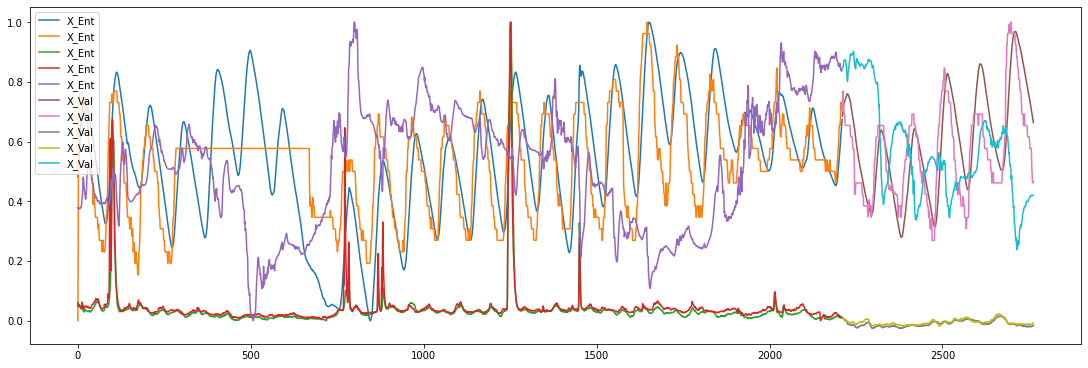

In [12]:
# Affiche quelques séries
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(df_etude.index[:temps_separation].values,serie_entrainement_X_norm[:,0:5], label="X_Ent")
ax.plot(df_etude.index[temps_separation:].values,serie_test_X_norm[:,0:5], label="X_Val")

ax.legend()
plt.show()

# Création des datasets

Les datasets sont créés de la manière suivante :

  <img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/Datasets_DSTP.png?raw=true' width=700/>

**1. Exemple de dataset**

In [13]:
X1 = np.linspace(1,100,100)
X2 = np.linspace(101,200,100)
X3 = np.linspace(201,300,100)
Y = np.linspace(301,400,100)

X1 = tf.expand_dims(X1,-1)
X2 = tf.expand_dims(X2,-1)
X3 = tf.expand_dims(X3,-1)
Y = tf.expand_dims(Y,-1)

Serie_X = tf.concat([X1,X2,X3],axis=1)
Serie_Y = Y
print(Serie_X.shape)

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),((X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT)}
# Y = YT+1, YT+2, YT+3, ...

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie+1, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie+1))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-longueur_sortie:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

test_dataset = prepare_dataset_XY(Serie_X,Serie_Y,10,4,1,1)

print(len(list(test_dataset.as_numpy_iterator())))
for element in test_dataset.take(2):
  print(element)

(100, 3)
86
((<tf.Tensor: shape=(1, 10, 3), dtype=float64, numpy=
array([[[  1., 101., 201.],
        [  2., 102., 202.],
        [  3., 103., 203.],
        [  4., 104., 204.],
        [  5., 105., 205.],
        [  6., 106., 206.],
        [  7., 107., 207.],
        [  8., 108., 208.],
        [  9., 109., 209.],
        [ 10., 110., 210.]]])>, <tf.Tensor: shape=(1, 10, 1), dtype=float64, numpy=
array([[[301.],
        [302.],
        [303.],
        [304.],
        [305.],
        [306.],
        [307.],
        [308.],
        [309.],
        [310.]]])>), <tf.Tensor: shape=(1, 4, 1), dtype=float64, numpy=
array([[[311.],
        [312.],
        [313.],
        [314.]]])>)
((<tf.Tensor: shape=(1, 10, 3), dtype=float64, numpy=
array([[[  2., 102., 202.],
        [  3., 103., 203.],
        [  4., 104., 204.],
        [  5., 105., 205.],
        [  6., 106., 206.],
        [  7., 107., 207.],
        [  8., 108., 208.],
        [  9., 109., 209.],
        [ 10., 110., 210.],
        

**2. Préparation des datasets**

In [14]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),((X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT)}
# Y = YT+1, YT+2, YT+3, ...

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie+1, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie+1))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-longueur_sortie:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

In [15]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 128
longueur_sequence = 20
longueur_sortie = 5
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm[:,0:-1],serie_entrainement_X_norm[:,-1:], longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm[:,0:-1],serie_test_X_norm[:,-1:],longueur_sequence,longueur_sortie,batch_size,shift)

In [16]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # (Y1,Y2,...,YT)
  print(element[1].shape)               # YT+1, YT+2, YT+3, ...

17
(128, 20, 18)
(128, 20, 1)
(128, 5, 1)


In [17]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # Y1,Y2,...,YT
  print(element[1].shape)               # YT+1,YT+2, YT+3...

4
(128, 20, 18)
(128, 20, 1)
(128, 5, 1)


**3. Préparation des X/Y**

In [18]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_train = [X1,X2]
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)


(2176, 20, 18)
(2176, 20, 1)
(2176, 5, 1)


In [19]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_val = [X1,X2]
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val[0].shape)
print(x_val[1].shape)
print(y_val.shape)


(512, 20, 18)
(512, 20, 1)
(512, 5, 1)


# Affichage des séries

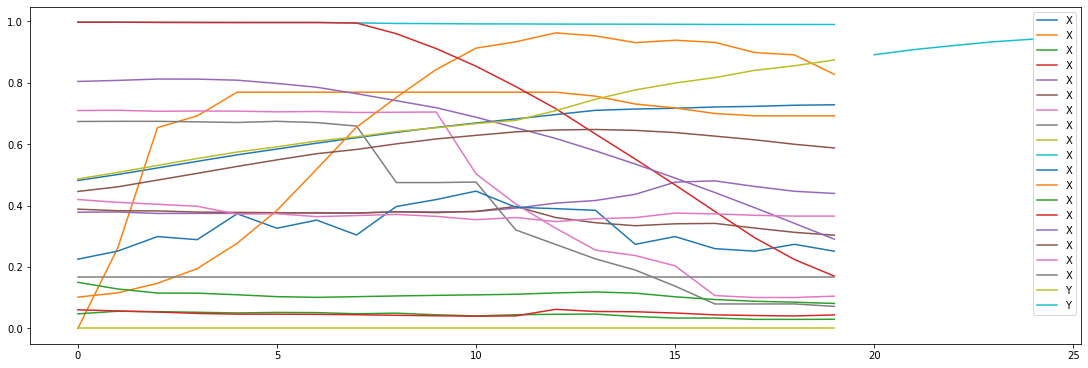

In [20]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(np.linspace(0,longueur_sequence-1,longueur_sequence),x_train[0][0,:,0:20],label="X")
ax.plot(np.linspace(0,longueur_sequence-1,longueur_sequence),x_train[1][0,:,:],label="Y")
ax.plot(np.linspace(longueur_sequence,longueur_sequence+longueur_sortie-1,longueur_sortie),y_train[0,:,:],label="Y")

ax.legend(loc="upper right")
plt.show()

# Création du modèle DSTPII-RNN

Le modèle DSTP-RNN implanté est le suivant :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/DSTPRNN-VueEnsemble.png?raw=true'>

**1. Création de la couche d'attention spatiale de l'étage n°1 / Phase 1**

On commence par créer la couche permettant de calculer le score. Cette fonction calcule le score de l'encodeur, c'est-à-dire le score à attribuer à chaque série d'entrée.  
Cette fonction est appellée par l'encodeur à l'aide de la méthode TimeDistribued de Keras, pour chaque série d'entrée.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/CalculScore__.png?raw=true' width=900>

In [21]:
class CalculScores_Encodeur_Phase1(tf.keras.layers.Layer):
  def __init__(self, dim_LSTM):
    self.dim_LSTM = dim_LSTM
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.Wf = self.add_weight(shape=(input_shape[1],2*self.dim_LSTM),initializer="normal",name="Wf")    # (Tin, 2x#LSTM)
    self.Uf = self.add_weight(shape=(input_shape[1],input_shape[1]),initializer="normal",name="Uf")     # (Tin, Tin)
    self.bf = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="bf")                  # (Tin, 1)
    self.vf = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="vf")                  # (Tin, 1)
    super().build(input_shape)        # Appel de la méthode build()
    
  def compute_output_shape(self, input_shape):
    return (input_shape[0], 1)

  #     hidd_state:     hidden_state        : (batch_size,#LSTM)
  #     cell_state:     Cell state          : (batch_size,#LSTM)]
  def SetStates(self,hidd_state, cell_state):
    self.hidd_state = hidd_state
    self.cell_state = cell_state

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,1)
  # Sorties :
  #     score:          Score               : (batch_size,1,1)
  def call(self, input):
    if self.hidd_state is not None:
        hs = tf.keras.layers.concatenate([self.hidd_state,self.cell_state],axis=1)        # (batch_size,2x#LSTM)
        hs = tf.expand_dims(hs,-1)                                              # (batch_size,2x#LSTM) => (batch_size,2#LSTM,1)
        e = tf.matmul(self.Wf,hs)                                               # (Tin,2x#LSTM)x(batch_size,2x#LSTM,1) = (batch_size,Tin,1)
        e = e + tf.matmul(self.Uf,input)                                        # (Tin,Tin)x(batch_size,Tin,1) = (batch_size,Tin,1)
        e = e + self.bf                                                         # (batch_size,Tin,1)
    else:
        e = tf.matmul(self.Uf,input)                                            # (Tin,Tin)x(batch_size,Tin,1) = (batch_size,Tin,1)
        e = e + self.bf                                                         # (batch_size,Tin,1)
    e = K.tanh(e)
    score = tf.matmul(tf.transpose(self.vf),e)                                  # (1,Tin)x(batch_size,Tin,1) = (batch_size,1,1)
    return tf.squeeze(score,-1)                                                 # (batch_size,1)

Puis maintenant la couche d'attention :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/EncodeurPhase1__.png?raw=true' width=900>

In [22]:
class Encodeur_Phase1(tf.keras.layers.Layer):
  def __init__(self, dim_LSTM, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_LSTM = dim_LSTM          # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_LSTM = tf.keras.layers.LSTM(self.dim_LSTM,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,recurrent_dropout=self.drop, name="LSTM_Encodeur")
    self.CalculScores_Encodeur_Phase1 = CalculScores_Encodeur_Phase1(dim_LSTM=self.dim_LSTM)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,#dim)
  #     hidd_state:     hidden_state        : (batch_size,#LSTM)
  #     cell_state:     Cell state          : (batch_size,#LSTM)]
  #     index:          index série         : (1)
  # Sorties :
  #     out_hid : Sortie vecteur caché      : (batch_size,#LSTM)
  #     out_cell: Sortie cell state         : (btach_size,#LSTM)
  #     x_tilda : Coupe temporelle pondérée : (batch_size,1,#dim)
  def call(self, input, hidd_state, cell_state, index):
    # Calcul des scores
    input_TD = tf.transpose(input,perm=[0,2,1])                               # (batch_size,Tin,#dim) => (batch_size,#dim,Tin)
    input_TD = tf.expand_dims(input_TD,axis=-1)                               # (batch_size,#dim,Tin) => (batch_size,#dim,Tin,1)
    self.CalculScores_Encodeur_Phase1.SetStates(hidd_state,cell_state)
    a = tf.keras.layers.TimeDistributed(
        self.CalculScores_Encodeur_Phase1)(input_TD)                          # (batch_size,#dim,Tin,1) : Timestep=#dim
                                                                              # (batch_size,Tin,1) envoyé #dim fois en //
                                                                              # (batch_size,#dim,1) retourné
    # Normalisation des scores alpha
    a = tf.keras.activations.softmax(a,axis=1)                                # (batch_size,#dim,1)

    # Applique les poids normalisés à la coupe temporelle des séries exogènes
    x_tilda = tf.multiply(tf.expand_dims(input[:,index,:],-1),a)              # (batch_size,#dim,1) _x_ (batch_size,#dim,1) = (batch_size,#dim,1)
    x_tilda = tf.transpose(x_tilda,perm=[0,2,1])                              # (batch_size,1,#dim)

    # Applique x_tilda à la cellule LSTM
    x_tilda = tf.transpose(x_tilda,perm=[0,2,1])                              # (batch_size,#dim,1)
    out_dec, out_hid, out_cell = self.couche_LSTM(x_tilda)                    # out_dec et out_cell : (batch_size,#LSTM)
    x_tilda = tf.transpose(x_tilda,perm=[0,2,1])                              # (batch_size,1,#dim)

    return out_hid, out_cell, x_tilda


**2. Création de la couche d'attention spatiale de l'étage n°1 / Phase 2**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/EncodeurPhase2_CalculScore__.png?raw=true'>

On commence par créer le calcul  du score :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/EncodeurPhase2_CalculScore2__.png?raw=true'>

In [23]:
class CalculScores_Encodeur_Phase2(tf.keras.layers.Layer):
  def __init__(self, dim_LSTM):
    self.dim_LSTM = dim_LSTM
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.Ws = self.add_weight(shape=(input_shape[1],2*self.dim_LSTM),initializer="normal",name="Ws")    # (Tin, 2x#LSTM)
    self.Us = self.add_weight(shape=(input_shape[1],input_shape[1]),initializer="normal",name="Us")     # (Tin, Tin)
    self.bs = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="bs")                  # (Tin, 1)
    self.vs = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="vs")                  # (Tin, 1)
    super().build(input_shape)        # Appel de la méthode build()
    
  def compute_output_shape(self, input_shape):
    return (input_shape[0], 1)

  #     hidd_state:     hidden_state        : (batch_size,#LSTM)
  #     cell_state:     Cell state          : (batch_size,#LSTM)]
  def SetStates(self,hidd_state, cell_state):
    self.hidd_state = hidd_state
    self.cell_state = cell_state

  # Entrées :
  #     input:          Entrées Z           : (batch_size,Tin,1)
  # Sorties :
  #     score:          Score               : (batch_size,1,1)
  def call(self, input):
    if self.hidd_state is not None:
        hs = tf.keras.layers.concatenate([self.hidd_state,self.cell_state],axis=1)        # (batch_size,2x#LSTM)
        hs = tf.expand_dims(hs,-1)                                              # (batch_size,2x#LSTM) => (batch_size,2#LSTM,1)
        e = tf.matmul(self.Ws,hs)                                               # (Tin,2x#LSTM)x(batch_size,2x#LSTM,1) = (batch_size,Tin,1)
        e = e + tf.matmul(self.Us,input)                                        # (Tin,Tin)x(batch_size,Tin,1) = (batch_size,Tin,1)
        e = e + self.bs                                                         # (batch_size,Tin,1)
    else:
        e = tf.matmul(self.Us,input)                                            # (Tin,Tin)x(batch_size,Tin,1) = (batch_size,Tin,1)
        e = e + self.bs                                                         # (batch_size,Tin,1)
    e = K.tanh(e)
    score = tf.matmul(tf.transpose(self.vs),e)                                  # (1,Tin)x(batch_size,Tin,1) = (batch_size,1,1)
    return tf.squeeze(score,-1)                                                 # (batch_size,1)

Puis maintenant la couche d'attention :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/EncodeurPhase22__.png?raw=true'>

In [24]:
class Encodeur_Phase2(tf.keras.layers.Layer):
  def __init__(self, dim_LSTM, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_LSTM = dim_LSTM          # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_LSTM = tf.keras.layers.LSTM(self.dim_LSTM,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,recurrent_dropout=self.drop, name="LSTM_Encodeur")
    self.CalculScores_Encodeur_Phase2 = CalculScores_Encodeur_Phase2(dim_LSTM=self.dim_LSTM)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:          Entrées Z           : (batch_size,Tin,2*#dim+2)
  #     hidd_state:     hidden_state        : (batch_size,#LSTM)
  #     cell_state:     Cell state          : (batch_size,#LSTM)]
  #     index:          index série         : (1)
  # Sorties :
  #     out_hid : Sortie vecteur caché      : (batch_size,#LSTM)
  #     out_cell: Sortie cell state         : (btach_size,#LSTM)
  def call(self, input, hidd_state, cell_state, index):
    # Calcul des scores
    input_TD = tf.transpose(input,perm=[0,2,1])                               # (batch_size,Tin,2*#dim+2) => (batch_size,2*#dim+2,Tin)
    input_TD = tf.expand_dims(input_TD,axis=-1)                               # (batch_size,2*#dim+2,Tin) => (batch_size,2*#dim+2,Tin,1)
    self.CalculScores_Encodeur_Phase2.SetStates(hidd_state,cell_state)
    b = tf.keras.layers.TimeDistributed(
        self.CalculScores_Encodeur_Phase2)(input_TD)                          # (batch_size,2*#dim+2,Tin,1) : Timestep=2*#dim+2
                                                                              # (batch_size,Tin,1) envoyé 2*#dim+2 fois en //
                                                                              # (batch_size,2*#dim+2,1) retourné
    # Normalisation des scores beta
    b = tf.keras.activations.softmax(b,axis=1)                                # (batch_size,2*#dim+2,1)

    # Applique les poids normalisés à la série
    z_tilda = tf.multiply(tf.expand_dims(input[:,index,:],-1),b)              # (batch_size,2*#dim+2,1) _x_ (batch_size,2*#dim+2,1) = (batch_size,2*#dim+2,1)
    z_tilda = tf.transpose(z_tilda,perm=[0,2,1])                              # (batch_size,1,2*#dim+2)

    # Applique z_tilda à la cellule LSTM
    z_tilda = tf.transpose(z_tilda,perm=[0,2,1])                              # (batch_size,2*#dim+2,1)
    out_dec, out_hid, out_cell = self.couche_LSTM(z_tilda)                    # out_dec et out_cell : (batch_size,#LSTM)
    z_tilda = tf.transpose(z_tilda,perm=[0,2,1])                              # (batch_size,1,2*#dim+2)

    return out_hid, out_cell


**3. Création de la couche d'attention du décodeur**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/CalculScoreDecodeur3.png?raw=true'>

On commence par créer la couche de calcul du score du décodeur.  
Cette fonction calcule le score du décodeur, c'est-à-dire le score à attribuer à chaque hidden-state en sortie de l'encodeur.  
Cette fonction est appellée par la couche d'attention temporelle du décodeur à l'aide de la méthode TimeDistribued de Keras.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/CalculScoreDecodeur4.png?raw=true'>

In [25]:
class CalculScores_Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_LSTM):
    self.dim_LSTM = dim_LSTM            # Dimension des vecteurs cachés
    super().__init__()                  # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.Wd = self.add_weight(shape=(self.dim_LSTM,2*self.dim_LSTM),initializer="normal",name="Wd")     # (#LSTM, 2x#LSTM)
    self.Ud = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Ud")       # (#LSTM, #LSTM)
    self.bd = self.add_weight(shape=(self.dim_LSTM,1),initializer="normal",name="bd")                   # (#LSTM, 1)
    self.vd = self.add_weight(shape=(self.dim_LSTM,1),initializer="normal",name="vd")                   # (#LSTM, 1)
    super().build(input_shape)        # Appel de la méthode build()

  def compute_output_shape(self, input_shape):
    return (input_shape[0], 1)


  #     hidd_state:     hidden_state        : (batch_size,#LSTM)
  #     cell_state:     Cell state          : (batch_size,#LSTM)
  def SetStates(self,hidd_state, cell_state):
    self.hidd_state = hidd_state
    self.cell_state = cell_state

  # Entrées :
  #     input:        Entrée score décodeur : (batch_size,#LSTM)
  # Sorties :
  #     score:        score                 : (batch_size,1)
  def call(self,input):
    input = tf.expand_dims(input,-1)
    if self.hidd_state is not None:
        hs = tf.keras.layers.concatenate([self.hidd_state,self.cell_state],axis=1)        # (batch_size,2x#LSTM)
        hs = tf.expand_dims(hs,-1)                                              # (batch_size,2x#LSTM) => (batch_size,2#LSTM,1)
        e = tf.matmul(self.Wd,hs)                                               # (#LSTM,2x#LSTM)x(batch_size,2x#LSTM,1) = (batch_size,#LSTM,1)
        e = e + tf.matmul(self.Ud,input)                                        # (#LSTM,#LSTM)x(batch_size,#LSTM,1) = (batch_size,#LSTM,1)
        e = e + self.bd                                                         # (batch_size,#LSTM,1)
    else:
        e = tf.matmul(self.Ud,input)                                            # (#LSTM,#LSTM)x(batch_size,#LSTM,1) = (batch_size,#LSTM,1)
        e = e + self.bd                                                         # (batch_size,#LSTM,1)
    e = K.tanh(e)
    score = tf.matmul(tf.transpose(self.vd),e)                                  # (1,#LSTM)x(batch_size,#LSTM,1) = (batch_size,1,1)
    score = tf.squeeze(score,-1)                                                # (batch_size,1)
    return score

Puis maintenant la couche d'attention :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/CalculScoreDecodeur5.png?raw=true'>

In [26]:
class CalculAttention_Decodeur(tf.keras.layers.Layer):
  def __init__(self, dim_LSTM):
    self.dim_LSTM = dim_LSTM          # Dimension des vecteurs cachés
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_CalculScores_Decodeur = CalculScores_Decodeur(dim_LSTM=self.dim_LSTM)
    super().build(input_shape)        # Appel de la méthode build()

  #     hidd_state:     hidden_state        : (batch_size,#LSTM)
  #     cell_state:     Cell state          : (batch_size,#LSTM)
  def SetStates(self,hidd_state, cell_state):
    self.hidd_state = hidd_state
    self.cell_state = cell_state

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,#LSTM)
  # Sorties :
  #     vect_contexte   Vecteur Contexte    : (batch_size,1,#LSTM)
  def call(self, input):
    # Calcul des scores
    self.couche_CalculScores_Decodeur.SetStates(self.hidd_state,self.cell_state)
    g = tf.keras.layers.TimeDistributed(
        self.couche_CalculScores_Decodeur)(input)                             # (batch_size,Tin,#LSTM) : Timestep=Tin
                                                                              # (batch_size,#LSTM) envoyé Tin fois en //
                                                                              # (batch_size,Tin,1) retourné
    # Normalisation des scores gama
    g = tf.keras.activations.softmax(g,axis=1)                                # (batch_size,Tin,1)

    # Calcul du vecteur contexte
    C = tf.multiply(input,g)        # (batch_size,Tin,#LSTM)_x_(batch_size,Tin,1) = (batch_size,Tin,#LSTM)
    C = K.sum(C,axis=1)             # (batch_size,#LSTM)
    C = tf.expand_dims(C,1)         # (batch_size,1,#LSTM)
    return C


**4. Création de la couche de décodeur**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/CoucheDecodeurAll.png?raw=true'>

In [27]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_LSTM, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_LSTM = dim_LSTM            # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_Attention_Decodeur = CalculAttention_Decodeur(dim_LSTM=self.dim_LSTM)
    self.couche_LSTM = tf.keras.layers.LSTM(self.dim_LSTM,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,recurrent_dropout=self.drop, name="LSTM_Decodeur")
    self.W = self.add_weight(shape=(self.dim_LSTM+1,1),initializer="normal",name="W")                   # (#LSTM+1, 1)
    self.b = self.add_weight(shape=(1,1),initializer="normal",name="b")                                 # (1, 1)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:        Entrée décodeur       : (batch_size,Tin,#LSTM)
  #     Y:            Yt                    : (batch_size,1,1)
  #     hid_state:    hidden state          : (batch_size,#LSTM)
  #     cell_state:   cell_state            : (batch_size,#LSTM)
  # Sorties :
  #     out_hid :     hidden_state          : (batch_size,#LSTM)
  #     out_cell :    cell_state            : (batch_size,#LSTM)
  #     v_contexte:   vecteur contexte      : (batch_size,#LSTM)
  def call(self,input,Y,hid_state,cell_state):
    # Calcul du vecteur contexte
    self.couche_Attention_Decodeur.SetStates(hid_state,cell_state)
    C = self.couche_Attention_Decodeur(input)           # (batch_size,1,#LSTM)

    # Calcul de Y_tilda
    add = tf.keras.layers.concatenate([Y,C],axis=2)     # (batch_size,1,#LSTM+1)
    add = tf.transpose(add,perm=[0,2,1])                # (batch_size,#LSTM+1,1)
    Y_tilda = tf.matmul(tf.transpose(self.W),add)       # (1,#LSTM+1) x (batch_size,#LSTM+1,1) = (batch_size,1,1)
    Y_tilda = Y_tilda + self.b

    # Calcul des hidden state et cell state
    if hid_state is not None:
      out_, out_hid, out_cell = self.couche_LSTM(Y_tilda,initial_state=[hid_state,cell_state])
    else:
      out_, out_hid, out_cell = self.couche_LSTM(Y_tilda)

    return out_hid,out_cell, C

**5. Création de la structure complète**

Il ne reste plus qu'à créer l'architecture complète et d'ajouter l'estimation de la sortie :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/DSTPRNN-VueEnsemble.png?raw=true'>

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/DSTPII.png?raw=true'>

# Création du modèle DSTPII Multistep + VAR + PID

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/VARPIDMULTI2.png?raw=true">

**1. Création de la couche VAR**

On met en place l'équation suivante :

${\phi _{T + t}} = \sum\limits_{i = 1}^T {{A_i} \cdot {x_i}}  + \sum\limits_{i = 1}^{t - 1} {{A_{T + i}} \cdot {{\hat Y}_{T + i}} + \xi }$

In [28]:
class VAR(tf.keras.layers.Layer):
  def __init__(self,longueur_sortie):
    self.longueur_sortie = longueur_sortie
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.Avar = self.add_weight(shape=(input_shape[1],input_shape[2]+1,input_shape[2]+1),initializer="normal",name="Avar")          # (Tin,#dim+1,#dim+1)
    self.Apred = self.add_weight(shape=(self.longueur_sortie,1),initializer="normal",name="Apred")                                  # (longueur_sortie,1)
    self.zeta = self.add_weight(shape=(1,1),initializer="normal",name="zeta")                                                       # (1,1)
    super().build(input_shape)        # Appel de la méthode build()
  
  # Entrées
  #     series_X  : Séries exogènes X           : (batch_size,Tin,#dim)
  #     cible_Y   : Cible                       : (batch_size,Tin,1)
  #     y_pred_1  : Prédiction globale à (t-1)  : (batch_size,1)
  #     index :     Pas de temps
  # Sorties
  #     phi       : Prédiction VAR              : (batch_size,1)
  def call(self,series_X,cible_Y,y_pred_1,index):
    entree = tf.keras.layers.concatenate([series_X,cible_Y],axis=2)                 # (batch_size,Tin,#dim+1)
    entree = tf.transpose(entree,perm=[0,2,1])                                      # (batch_size,#dim+1,Tin)

    # Algorithme VAR
    sortie = []
    for i in range(series_X.shape[1]):
      sortie.append(tf.matmul(self.Avar[i,:,:],entree[:,:,i:i+1]))                  # (#dim+1,#dim+1)x(batch_size,#dim+1,1)=(batch_size,#dim+1,1)
    sortie = tf.convert_to_tensor(sortie)                                           # (Tin,batch_size,#dim+1,1)
    sortie = tf.transpose(sortie,perm=[1,0,2,3])                                    # (batch_size,Tin,#dim+1,1)
    sortie = K.sum(sortie,axis=1)                                                   # (batch_size,#dim+1,1)

    # Récupère la prédiction de la cible
    sortie = sortie[:,-1,:]                                                         # (batch_size,1)

    # Ajoute la combinaison linéaire de la prédiction globale à (t-1)
    sortie = tf.expand_dims(sortie,-1) + tf.matmul(self.Apred[index:index+1,:],tf.expand_dims(y_pred_1,-1))             # (batch_size,1,1) + (1,1)x(batch_size,1,1) = (batch_size,1,1)
    sortie = tf.squeeze(sortie,-1) + self.zeta                                                         # (batch_size,1)
    return sortie

**2. Ajout du correcteur PID**

In [29]:
class Correcteur_PID(tf.keras.layers.Layer):
  def __init__(self,batch_size,couche):
    super().__init__()                # Appel du __init__() de la classe Layer
    self.erreur_1 = tf.Variable(shape=(batch_size,1),trainable=False,initial_value=tf.zeros(shape=(batch_size,1)),name="erreur_1")               # (BS,1) = 0
    self.num_iteration = tf.Variable(shape=(batch_size,1),trainable=False,initial_value=tf.ones(shape=(batch_size,1)),name="iteration")          # (BS,1) = 1
    self.couche = couche
    self.init = False
  
  def build(self,input_shape):
    self.Couche_Dense_P = tf.keras.layers.Dense(units=1,use_bias=False,kernel_initializer=tf.keras.initializers.Ones(),trainable=True,name="CoucheP")
    self.Couche_Dense_I = tf.keras.layers.Dense(units=1,use_bias=False,kernel_initializer=tf.keras.initializers.Zeros(),trainable=True,name="CoucheI")
    self.Couche_Dense_D = tf.keras.layers.Dense(units=1,use_bias=False,kernel_initializer=tf.keras.initializers.Zeros(),trainable=True,name="CoucheD")
    self.Couche_DenseII = tf.keras.layers.Dense(units=1,use_bias=True,kernel_initializer=tf.keras.initializers.Ones(),trainable=True,activation=self.couche,name="CoucheFNNII")
    super().build(input_shape)        # Appel de la méthode build()
  

  # Entrées
  #     y_tilda_1 :   Prédiction initiale à (t-1) :   (batch_size,1)
  #     y_pred_1  :   Prédiction globale à (t-1)  :   (batch_size,1)
  # Sorties
  #     PID(erreur) : Erreur traitée par PID      :   (batch_size,1)
  def call(self, y_tilda_1,y_pred_1):
    # Calcul de l'erreur courante
    erreur = y_pred_1-y_tilda_1                                                   # (batch_size,1)

    # Calcul de la partie proportionnelle
    P = self.Couche_Dense_P(erreur)                                               # (batch_size,1)

    # Calcul de la partie intégrale
    I = (1/self.num_iteration)*self.Couche_Dense_I(self.erreur_1+erreur)          # (batch_size,1)

    # Calcul de la partie dérivée
    D = self.Couche_Dense_D(erreur-self.erreur_1)                                 # (batch_size,1)
    
    # Sauvegarde des erreurs et #itérations
    self.num_iteration.assign(self.num_iteration+1)                               # (batch_size,1)
    self.erreur_1.assign(erreur + self.erreur_1)                                  # (batch_size,1)

    return self.Couche_DenseII(tf.keras.layers.Concatenate(axis=1)([P,I,D]))        # (batch_size,1)

**3. Création de la couche DSTPII+VAR+PID**

In [35]:
class Net_DSTPRNNII_VARPID(tf.keras.layers.Layer):
  def __init__(self,encodeur_phase1_I, encodeur_phase1_II, encodeur_phase2,decodeur,pred_VAR, correcteur_PID,longueur_sequence, longueur_sortie, dim_LSTM, regul=0.0, drop = 0.0):
    self.encodeur_phase1_I = encodeur_phase1_I
    self.encodeur_phase1_II = encodeur_phase1_II
    self.encodeur_phase2 = encodeur_phase2
    self.decodeur = decodeur
    self.pred_VAR = pred_VAR
    self.correcteur_PID = correcteur_PID
    self.longueur_sequence = longueur_sequence
    self.longueur_sortie = longueur_sortie
    self.regul = regul
    self.drop = drop
    self.dim_LSTM = dim_LSTM
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.Wy = self.add_weight(shape=(self.longueur_sortie,self.dim_LSTM,2*self.dim_LSTM),initializer="normal",name="Wy")        # (longueur_sortie,#LSTM, 2x#LSTM)
    self.by = self.add_weight(shape=(self.longueur_sortie,self.dim_LSTM,1),initializer="normal",name="by")                      # (longueur_sortie,#LSTM, 1)
    self.vy = self.add_weight(shape=(self.longueur_sortie,self.dim_LSTM,1),initializer="normal",name="vy")                      # (longueur_sortie,#LSTM,1)
    self.Couche_DenseI = tf.keras.layers.Dense(units=1,use_bias=True,name="CoucheFNNI")
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,#dim)
  #     output_seq:     Sortie séquence Y   : (batch_size,Tin,1)
  # Sorties :
  #     sortie:         Prédiction Y        : (batch_size,longueur_sortie,1)
  def call(self,input,output_seq):
    # Phase n°1-I d'encodage
    # Calcul les représentations spatiales pondérées
    # des coupes temporelles des séries exogènes en entrée
    # x_tilda_1
    x_tilda_1 = []
    hid_state = None
    cell_state = None
    for i in range(input.shape[1]):
      hid_state, cell_state, x_t = self.encodeur_phase1_I(input,hid_state,cell_state,i)
      x_t = tf.squeeze(x_t,1)                         # (batch_size,1,#dim) => (batch_size,#dim)
      x_tilda_1.append(x_t)                           # (batch_size,#dim)
    x_tilda_1 = tf.convert_to_tensor(x_tilda_1)       # (Tin,batch_size,#dim)
    x_tilda_1 = tf.transpose(x_tilda_1,perm=[1,0,2])  # (batch_size,Tin,#dim)

    # Phase n°1-II d'encodage
    # Calcul les représentations spatiales pondérées
    # des coupes temporelles des séries exogènes en entrée
    # x_tilda_2
    x_tilda_2 = []
    hid_state = None
    cell_state = None
    for i in range(input.shape[1]):
      hid_state, cell_state, x_t = self.encodeur_phase1_II(tf.keras.layers.concatenate([input,output_seq],axis=2),hid_state,cell_state,i)
      x_t = tf.squeeze(x_t,1)                           # (batch_size,1,#dim+1) => (batch_size,#dim+1)
      x_tilda_2.append(x_t)                             # (batch_size,#dim+1)
    x_tilda_2 = tf.convert_to_tensor(x_tilda_2)         # (Tin,batch_size,#dim+1)
    x_tilda_2 = tf.transpose(x_tilda_2,perm=[1,0,2])    # (batch_size,Tin,#dim+1)

    # Concaténation des sorties des phases 1-II et de la série cible
    Z2 = []
    for i in range(input.shape[1]):
      z = tf.keras.layers.concatenate([x_tilda_2[:,i,:],                  # (batch_size,#dim+1)
                                       output_seq[:,i,:]]                 # (batch_size,1)
                                      ,axis=1)                            # = (batch_size,#dim+2)
      Z2.append(z)
    Z2 = tf.convert_to_tensor(Z2)                   # (Tin,batch_size,#dim+2)
    Z2 = tf.transpose(Z2,perm=[1,0,2])              # (batch_size,Tin,#dim+2)

    # Concaténation des sorties des phases 1-I avec Z2
    Z = tf.keras.layers.concatenate([x_tilda_1,Z2],axis=2)  # (batch_size,Tin,2*#dim+2)

    # Phase n°2 d'encodage
    # Création des représentations cachées des
    # concaténations précédentes
    hid = []
    hid_state = None
    cell_state = None
    for i in range(input.shape[1]):
      hid_state, cell_state = self.encodeur_phase2(Z,hid_state,cell_state,i)
      hid.append(hid_state)
    hid = tf.convert_to_tensor(hid)               # (Tin,batch_size,#LSTM)
    hid = tf.transpose(hid,perm=[1,0,2])          # (batch_size,Tin,#LSTM)


    # Phase de décodage
    # Récupère les états cachés à (T-1)
    hid_ = None
    cell_ = None
    for i in range(0,output_seq.shape[1]-1):
      hid_, cell_, vc = self.decodeur(hid,output_seq[:,i:i+1,:],hid_,cell_)
    
    # hid_  : hT-1    : hidden state à t=T-1
    # cell_ : sT-1    : cell state à t=T-1
    # vc    : CT-1    : vecteur contexte à t=T-1
    
    # Estimation des sorties
    # hid_ : (batch_size,#LSTM)
    # vc   : (batch_size,1,#LSTM)
    Y = []
    y = tf.expand_dims(output_seq[:,-1,:],-1)        # y = YT : (batch_size,1,1)

    y_pred_1 = tf.matmul(input[:,0:1,0:1],tf.zeros(shape=(1,1)))             # (batch_size,1,1)x(1,1) = (batch_size,1,1)
    y_pred_initial_1 = tf.matmul(input[:,0:1,0:1],tf.zeros(shape=(1,1)))     # (batch_size,1,1)x(1,1) = (batch_size,1,1)

    y_pred_1 = tf.squeeze(y_pred_1,-1)                            # (batch_size,1)
    y_pred_initial_1 = tf.squeeze(y_pred_initial_1,-1)            # (batch_size,1)


    for i in range(0,self.longueur_sortie):
      # Prédiction DSTPII
      hid_, cell_, vc = self.decodeur(hid,y,hid_,cell_)
      add = tf.keras.layers.concatenate([tf.expand_dims(hid_,1),vc],axis=2)         # (batch_size,1,2x#LSTM)
      add = tf.transpose(add,perm=[0,2,1])                                          # (batch_size,2x#LSTM,1)
      y_dstpii = tf.matmul(self.Wy[i,:,:],add)                                      # (#LSTM,2x#LSTM) x (batch_size,2x#LSTM+1,1) = (batch_size,#LSTM,1)
      y_dstpii = y_dstpii + self.by[i,:,:]                                            # (batch_size,#LSTM,1)
      y_dstpii = tf.matmul(tf.transpose(self.vy[i,:,:]),y_dstpii)                     # (1,#LSTM)x(batch_size,#LSTM,1) = (batch_size,1,1)
      y_dstpii = tf.squeeze(y_dstpii,-1)                                              # (batch_size,1)

      # Prédiction VAR
      y_var = self.pred_VAR(input,output_seq,y_pred_1,i)                                                       # (batch_size,1)

      # Prédiction initiale
      pred_initial = self.Couche_DenseI(tf.keras.layers.Concatenate(axis=1)([y_dstpii,y_var]))        # (batch_size,1)

      # Calcul de l'erreur avec le PID à partir des prédictions initiales et globales à (t-1)
      erreur = self.correcteur_PID(y_pred_initial_1,y_pred_1)                                        # (batch_size,1)

      # Applique l'erreur à la prédiction initiale
      y_pred = pred_initial + erreur

      # Sauvegarde la prédiction
      Y.append(y_pred)

      # Met à jour les prédictions à (t-1)
      y_pred_initial_1 = pred_initial
      y_pred_1 = y_pred

      y = tf.expand_dims(y_pred,-1)

    Y = tf.convert_to_tensor(Y)               # (longueur_sortie,batch_size,1)
    Y = tf.transpose(Y,perm=[1,0,2])          # (batch_size,longueur_sortie,1)
    return Y

#Création du modèle global

In [36]:
dim_LSTM = 128
drop=0.0
l2reg=0.0

def get_model():
  entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,x_train[0].shape[2]),batch_size=batch_size)
  sorties_sequence = tf.keras.layers.Input(shape=(longueur_sequence,1),batch_size=batch_size)

  encodeur_P1_I = Encodeur_Phase1(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)
  encodeur_P1_II = Encodeur_Phase1(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)
  encodeur_P2 = Encodeur_Phase2(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)
  decodeur = Decodeur(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)
  pred_VAR=VAR(longueur_sortie=longueur_sortie)
  correcteur = Correcteur_PID(batch_size=batch_size,couche="tanh")

  sortie = Net_DSTPRNNII_VARPID(encodeur_P1_I,encodeur_P1_II,encodeur_P2,decodeur,pred_VAR=pred_VAR,correcteur_PID=correcteur, longueur_sequence=longueur_sequence,longueur_sortie=longueur_sortie, dim_LSTM=dim_LSTM,regul=l2reg,drop=drop)(entrees_sequences,sorties_sequence)

  model = tf.keras.Model([entrees_sequences,sorties_sequence],sortie)
  return model

# Entrainement TPU

In [ ]:
from google.colab import files

max_periodes = 500

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle
  model = get_model()

  # Définition des paramètres liés à l'évolution du taux d'apprentissage
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.001,
      decay_steps=50,
      decay_rate=0.01)

  optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur)

  # Entraine le modèle
  historique = model.fit(x=[x_train[0],x_train[1]],y=y_train,validation_data=([x_val[0],x_val[1]],y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)],batch_size=batch_size)

files.download('poids_train.hdf5')

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/500
17/17 [==============================] - 257s 3s/step - loss: 0.0945 - val_loss: 0.0249

Epoch 00001: loss improved from inf to 0.09445, saving model to poids_train.hdf5
Epoch 2/500
17/17 [==============================] - 1s 76ms/step - loss: 0.0183 - val_loss: 0.0239

Epoch 00002: loss improved from 0.09445 to 0.01832, saving model to poids_train.hdf5
Epoch 3/500
17/17 [==============================] - 1s 75ms/step - loss: 0.0113 - val_loss: 0.0136

Epoch 00003: loss improved from 0.01832 to 0.01126, saving model to poids_train.hdf5
Epoch 4/500
17/17 [==============================] - 1s 75ms/step - loss: 0.0086 - val_loss: 0.0106

Epoch 00004: loss improved from 0.01126 to 0.00862, saving model to poids_train.hdf5
Epoch 5/500
17/17 [==============================] - 1s 76ms/step - loss: 0.0071 - val_loss: 0.0089

Epoch 00005: loss improved from 0.00862 to 0.00709, saving model to poids_train.hdf5
Epoch 6/500
17/17 [==============================] - 1s 79ms/step - loss: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.load_weights("poids_train.hdf5")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

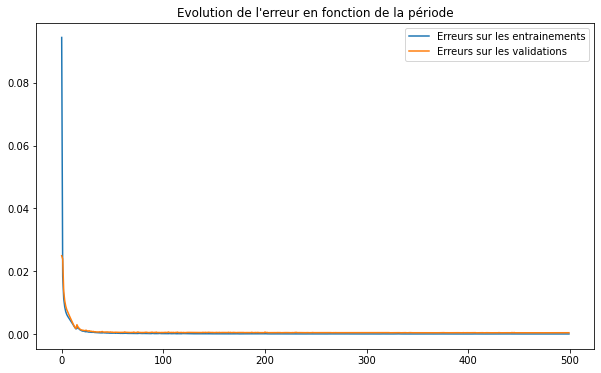

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

# Chargement du modèle pré-entrainé

In [ ]:
!rm *.hdf5
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Models/Multi_HRHN_VAR_PID_SML2010_MultiStep.hdf5"

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  model = get_model()
  model.compile(loss="mse",metrics="mse")
  model.fit(x=[x_train[0],x_train[1]],y=y_train, epochs=1)

In [ ]:
model.load_weights("Multi_HRHN_VAR_PID_SML2010_MultiStep.hdf5")

# Prédictions multi-step

In [ ]:
pred_ent = model.predict(dataset,verbose=1)
pred_val = model.predict(dataset_val,verbose=1)

4/4 [==============================] - 1s 23ms/step


In [ ]:
import plotly.graph_objects as go

decalage = longueur_sortie

fig = go.Figure()

# Affiche les courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=tf.squeeze(serie_entrainement_X_norm[:,-1:],-1),line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=tf.squeeze(serie_test_X_norm[:,-1:],-1),line=dict(color='red', width=1)))

#Calcul les prédictions sur l'entrainement
pred = []
pred_index = []
step_time = []
step_val = []

max = int(len(pred_ent)/longueur_sortie)
#max = 10
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i*longueur_sortie,0:decalage,:],1))
  pred_index.append(df_etude.index[longueur_sequence+i*longueur_sortie:longueur_sequence+(i+1)*longueur_sortie])
  step_val.append(pred_ent[i*longueur_sortie,0,0])
  step_time.append(df_etude.index[longueur_sequence+i*longueur_sortie])

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

pred_index = np.asarray(pred_index)
pred_index = np.reshape(pred_index,(pred_index.shape[0]*pred_index.shape[1]))

fig.add_trace(go.Scatter(x=pred_index,y=pred, mode='lines', line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=step_time,y=step_val, mode='markers', line=dict(color='black', width=1)))

#Calcul les prédictions sur les validations
pred = []
pred_index = []
step_time = []
step_val = []
max = int(len(pred_val)/longueur_sortie)
#max = 10
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i*longueur_sortie,0:decalage,:],1))
  pred_index.append(df_etude.index[temps_separation+i*decalage+longueur_sequence:temps_separation+i*decalage+longueur_sequence+longueur_sortie])
  step_val.append(pred_val[i*longueur_sortie,0,0])
  step_time.append(df_etude.index[temps_separation+i*decalage+longueur_sequence])

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))
pred_index = np.asarray(pred_index)
pred_index = np.reshape(pred_index,(pred_index.shape[0]*pred_index.shape[1]))

fig.add_trace(go.Scatter(x=pred_index,y=pred, mode='lines', line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=step_time,y=step_val, mode='markers', line=dict(color='black', width=1)))

# Affiche les prédictions
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Erreurs en multi step**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = longueur_sortie

#Calcul les prédictions sur l'entrainement
pred = []
pred_index = []
step_time = []
step_val = []

max = int(len(pred_ent)/longueur_sortie)
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i*longueur_sortie,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_ent = tf.keras.losses.mse(serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

#Calcul les prédictions sur les validations
pred = []
max = int(len(pred_val)/longueur_sortie)
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i*longueur_sortie,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_test = tf.keras.losses.mse(serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)